<a href="https://colab.research.google.com/github/ElmPartners/Public/blob/master/Cap_Gains_Decisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Should I realize gains if cap-gains rates are about to rise?

The capital gains tax rate $\tau_0$ will be changing tomorrow to $\tau$.  You have some amount of homogenous unrealized gains $g_0$, and you want to know whether you should realize your gains now (or more generally what fraction should be realized), given that you also want to hold the optimal amount of the risky asset to horizon $T$, at which point you'll realize any additional gains and pay any taxes.  

We assume the risky asset $S$ follows a GBM with mean return $\mu$ and volatility $\sigma$, and that you have CRRA utility with elasticity $\gamma$.  $S$ also pays a dividend at rate $\delta$ which is taxed at $\tau_d$.  

As usual we want to optimize expected utility:

\begin{equation}
U(\theta,\kappa) =  \mathbb{E}[u(\hat{P}_T)] \tag{1}
\end{equation}

where:

\begin{equation}
u(w) = \frac{w^{1-\gamma} - 1}{1 - \gamma}
\end{equation}

\begin{equation}
\hat{P}_T = P_T - ((1-\theta-\epsilon)g + P_T - P_0 - \Delta)^+\tau \tag{2}
\end{equation}

\begin{equation}
\Delta = \frac{1}{2}(P_T + P_0)\kappa\delta T \tag{3}
\end{equation}

\begin{equation}
\epsilon = \frac{1}{\kappa_0}((\kappa-\kappa_0)^+ - \kappa_0\theta)^+ \tag{4}
\end{equation}

\begin{equation}
P_T = P_0 e^{(\kappa(\mu - \delta\tau_d) + (1-\kappa)(1-\tau_d)r-\frac{1}{2}\kappa^2\sigma^2)T + \kappa\sigma Z_T} \tag{5}
\end{equation}

\begin{equation}
P_0 = 1 - (\theta + \epsilon) g \tau_0 \tag{6}
\end{equation}

Note: $\Delta$ is an approximation for the amount of total return coming from dividends, and $\epsilon$ is the amount of extra immediate gain realization (if any) additional to $\theta$ called for by rebalancing the risk asset from $\kappa_0$ to $\kappa$.





In [50]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as pyp


# Inputs
gamma = 2

g = 0.4
tau_0 = 0.3
tau_vec = np.array([0.5, 0.5, 0.5])
tau_prob = np.array([0.33, 0.33, 0.33])
tau_d = 0.5

r = 0.01
mu = 0.06
sigma = 0.2
delta = 0.02
T = 20

int_range = 5
int_step = 0.01
theta_step = 0.25
kappa_step = 0.01
g_step = 0.01

In [51]:
# Some inline functions we need
u = lambda x: (np.power(x, 1-gamma) - 1) / (1 - gamma)
Delta = lambda x, y, kappa: 0.5 * (y + x) * kappa * delta * T
P_0 = lambda theta: 1 - theta * g * tau_0
P_hat = lambda P, theta, kappa, tau:  P - np.maximum(0, ((1 - theta) * g + P - P_0(theta) - Delta(P_0(theta), P, kappa))) * tau
P_T = lambda theta, kappa, z: P_0(theta) * np.exp((kappa*(mu-delta*tau_d) + (1-kappa)*(1-tau_d)*r - 0.5*pow(kappa, 2)*pow(sigma, 2))*T +
                                                  kappa*sigma*pow(T, 0.5)*z)

# And some data structures
z_size = int(2 * int_range/int_step + 1)
tau_size = len(tau_vec)
Z = np.ones((tau_size, 1)) @ np.linspace(-int_range, int_range, endpoint=True, num=z_size)[None, :]
tau = tau_vec[:, None] @ np.ones((1, z_size))
probs = tau_prob[:, None] * norm.pdf(Z)


In [52]:
def expected_util(x: np.array, optim: bool = False) -> float:
    # x[0] = theta
    # X[1] = kappa
    E_u = (u(P_hat(P_T(x[0], x[1], Z), x[0], x[1], tau)) * probs).sum() / probs.sum()

    return (-1 if optim else 1) * E_u

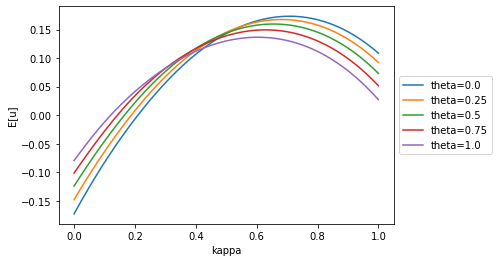

In [53]:
# The Main Event
theta_vec = np.linspace(0, 1, endpoint=True, num=int(1/theta_step+1))
kappa_vec = np.linspace(0, 1, endpoint=True, num=int(1/kappa_step+1))
u_mat = np.zeros((len(theta_vec), len(kappa_vec)))

for i, theta in enumerate(theta_vec):
    for j, kappa in enumerate(kappa_vec):
        u_mat[i, j] = expected_util(np.asarray([theta, kappa]))

# Display
for i, theta in enumerate(theta_vec):
    pyp.plot(kappa_vec, u_mat[i, :], label='theta={}'.format(theta))
pyp.xlabel('kappa')
pyp.ylabel('E[u]')
pyp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
pyp.show()



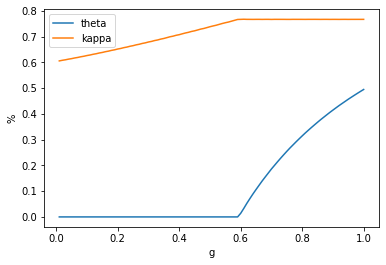

In [54]:
# The Main Event Pt II
# Plotting optimal theta and kappa against the amount of starting gain (g)

g_vec = np.linspace(g_step, 1, endpoint=True, num=int(1/g_step))
res_vec = np.zeros((2, g_vec.shape[0]))
bnds = [(0, 1), (0, 1)]
x0 = np.array([0.5, 0.5])
for i,g in enumerate(g_vec):
  res_vec[:, i] = minimize(expected_util, x0, args=(True), bounds=bnds).x
  
# Output
pyp.plot(g_vec, res_vec[0,:],label='theta')
pyp.plot(g_vec, res_vec[1,:],label='kappa')
pyp.xlabel('g')
pyp.ylabel('%')
pyp.legend()
pyp.show()
